<a href="https://colab.research.google.com/github/Isi2000/NX/blob/main/VOTER_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
from datetime import datetime
import os
import random
from tqdm import tqdm
import chardet
from collections import defaultdict
import math

from IPython.display import clear_output


In [ ]:
# Load data
def load_data():
    !git clone https://github.com/Isi2000/NX.git

    # Load MVP data
    df_MVP = pd.read_csv('/content/NX/MVP_2022_2023.txt', sep='\t', skiprows=[0])

    # Detect encoding for the other files
    with open('/content/NX/EMBID_DATA.txt', 'rb') as rawdata:
        encoding = chardet.detect(rawdata.read())['encoding']

    # Load other dataframes with detected encoding
    df_EMBID = pd.read_csv('/content/NX/EMBID_DATA.txt', sep='\t', encoding=encoding)
    df_JOKER = pd.read_csv('/content/NX/JOKER_DATA.txt', sep='\t', encoding=encoding)
    df_GIANNIS = pd.read_csv('/content/NX/GIANNIS_DATA.txt', sep='\t', encoding=encoding)
    print(df_EMBID.columns)
    return df_MVP, df_EMBID, df_JOKER, df_GIANNIS

# Process player data
def process_player_data(df_list, player_names):
    players_data = {}
    for name, df in zip(player_names, df_list):
        df_temp = df[['DATE', 'SCORE', 'PTS', 'EFF', 'REB', 'AST', 'MIN']].dropna().reset_index()
        df_temp['DATE'] = df_temp['DATE'].apply(convert_date)
        df_temp['SCORE'] = df_temp['SCORE'].apply(take_first)
        players_data[name] = df_temp
    return players_data

convert_date = lambda x: datetime.strptime(x, '%d-%b-%y').strftime('%d-%m-%Y')

take_first = lambda x: {'L': 0, 'W': 1}[x[0]]

def compute_normalized_yearly_averages(players_data, ordered_months):
    values_per_month = {name: [] for name in player_names}
    for month in ordered_months:
        for name in player_names:
            monthly_data = players_data[name][players_data[name]['DATE'].str[3:5] == str(month).zfill(2)]
            avg_pts = monthly_data['PTS'].mean()
            avg_eff = monthly_data['EFF'].mean()
            avg_ast = monthly_data['AST'].mean()
            avg_min = monthly_data['MIN'].mean()
            value = ((avg_eff+ math.sqrt(avg_pts + avg_ast)) *(avg_min**2/(48**2)))  # Include avg_ast in the value
            values_per_month[name].append(value)

    yearly_averages = [sum(values_per_month[name]) / len(ordered_months) for name in player_names]
    total_yearly_average = sum(yearly_averages)
    normalized_yearly_averages = [value / total_yearly_average for value in yearly_averages]
    print(yearly_averages)
    return normalized_yearly_averages

def initialize_ballot(voter_nodes, player_names, normalized_yearly_averages):
    """Initialize the ballot with voters' choices."""
    return {voter: np.random.choice(player_names, size = None, p=normalized_yearly_averages) for voter in voter_nodes}

def update_voter_choice(voter, neighbors, ballot):
    """Update the voter's choice based on neighbors' choices."""
    neighbor_choices = [ballot[neighbor] for neighbor in neighbors]
    return Counter(neighbor_choices).most_common(1)[0][0]

def analyze_network(G, voter_nodes, player_names, ballot):
    """Analyze the bipartite network."""
    player_popularity = Counter(ballot.values())
    voter_consistency = sum(1 for voter, player in ballot.items() if G.has_edge(voter, player))
    degree_distribution_voters = [G.degree(voter) for voter in voter_nodes]
    degree_distribution_players = [G.degree(player) for player in player_names]
    avg_clustering_coefficient = nx.average_clustering(G)

    return {
        "player_popularity": player_popularity,
        "voter_consistency": voter_consistency / len(voter_nodes),
        "degree_distribution_voters": degree_distribution_voters,
        "degree_distribution_players": degree_distribution_players,
        "avg_clustering_coefficient": avg_clustering_coefficient
    }

def get_previous_next_elements(my_list, element):
    index = my_list.index(element)

    # Previous and next elements
    previous_element = my_list[index - 1] if index > 0 else my_list[-1]
    next_element = my_list[index + 1] if index < len(my_list) - 1 else my_list[0]

    # Calculate the element above
    above_element = my_list[index - 10] if index >= 10 else my_list[index + 90]

    # Calculate the element below
    below_element = my_list[index + 10] if index < 90 else my_list[index - 90]

    return previous_element, next_element, above_element, below_element



def plot_bipartite_graph(G, simulation):
    clear_output(wait=True)  # Clear the current output before plotting
    pos = nx.bipartite_layout(G, df_MVP['Voter'])
    nx.draw(G, pos, with_labels=True, font_size=5, node_size=1, edge_color='blue', width=0.2)
    plt.title(f'Iteration {simulation}')
    plt.show()

In [ ]:
df_MVP, df_EMBID, df_JOKER, df_GIANNIS = load_data()
player_names = ['EMBID', 'JOKER', 'GIANNIS']
df_list = [df_EMBID, df_JOKER, df_GIANNIS]
players_data = process_player_data(df_list, player_names)
ordered_months = [10, 11, 12, 1, 2, 3, 4]
normalized_yearly_averages = compute_normalized_yearly_averages(players_data, ordered_months)

num_iterations =  17
num_simulations = 100

color_map = {player_names[0]: 'red', player_names[1]: 'blue', player_names[2]: 'green'}

simulation_results = []
voter_player_frequency = defaultdict(lambda: defaultdict(int))

# Initialize running totals for metrics
total_degrees = defaultdict(int)
total_clustering = defaultdict(float)
total_centrality = defaultdict(float)


chosen_player_colors = []
voter_positions = {voter: (i % 10, i // 10) for i, voter in enumerate(df_MVP['Voter'])}
data = {}
for i in tqdm(range(num_simulations)):
    G = nx.Graph()
    G.add_nodes_from(df_MVP['Voter'], bipartite=0)
    G.add_nodes_from(player_names, bipartite=1)
    voter_nodes = [n for n, d in G.nodes(data=True) if d["bipartite"] == 0]
    ballot = initialize_ballot(voter_nodes, player_names, normalized_yearly_averages)

    for _ in range(num_iterations):
        for voter, player in ballot.items():
            if G.has_edge(voter, player):
                G.remove_edge(voter, player)

        for voter in voter_nodes:
            # Add new edges to other voters
            neighbors = get_previous_next_elements(voter_nodes, voter)
            G.add_edge(voter, neighbors[0])
            G.add_edge(voter, neighbors[1])
            G.add_edge(voter, neighbors[2])
            G.add_edge(voter, neighbors[3])
            ballot[voter] = ballot[np.random.choice(neighbors)]
            G.add_edge(voter, ballot[voter])  # Add edge to the chosen player

    # Update player frequencies for each voter
    for voter, player in ballot.items():
        voter_player_frequency[voter][player] += 1

    # Update running totals for metrics
    for player in player_names:
        total_degrees[player] += G.degree(player)
        total_clustering[player] += nx.clustering(G, nodes=[player])[player]
        total_centrality[player] += nx.degree_centrality(G)[player]

    data[i] = [(voter, ballot[voter]) for voter in voter_nodes]
print(data)

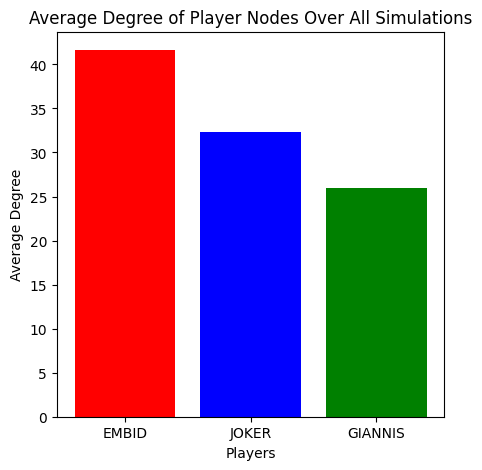

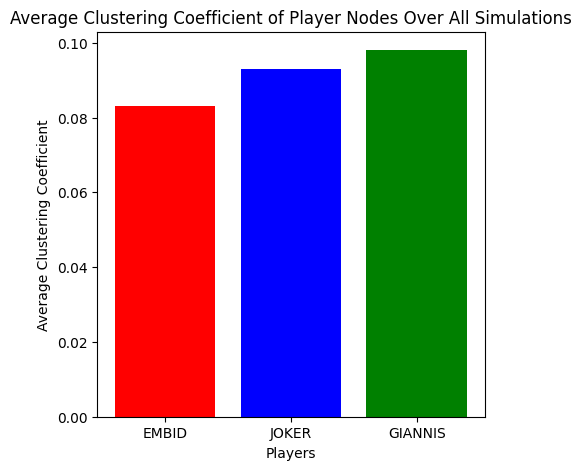

In [ ]:
# Compute averages
average_degrees = {player: total_degrees[player] / num_simulations for player in player_names}
average_clustering = {player: total_clustering[player] / num_simulations for player in player_names}
average_centrality = {player: total_centrality[player] / num_simulations for player in player_names}

plt.figure(figsize=(5, 5))
degrees = [average_degrees[player] for player in player_names]
colors = [color_map[player] for player in player_names]
plt.bar(player_names, degrees, color=colors)
plt.title('Average Degree of Player Nodes Over All Simulations')
plt.xlabel('Players')
plt.ylabel('Average Degree')
plt.show()

# Plotting Average Clustering Coefficients
plt.figure(figsize=(5, 5))
clustering_values = [average_clustering[player] for player in player_names]
plt.bar(player_names, clustering_values, color=colors)
plt.title('Average Clustering Coefficient of Player Nodes Over All Simulations')
plt.xlabel('Players')
plt.ylabel('Average Clustering Coefficient')
plt.show()




In [ ]:
print(average_degrees)

{'EMBID': 41.63, 'JOKER': 32.35, 'GIANNIS': 26.02}


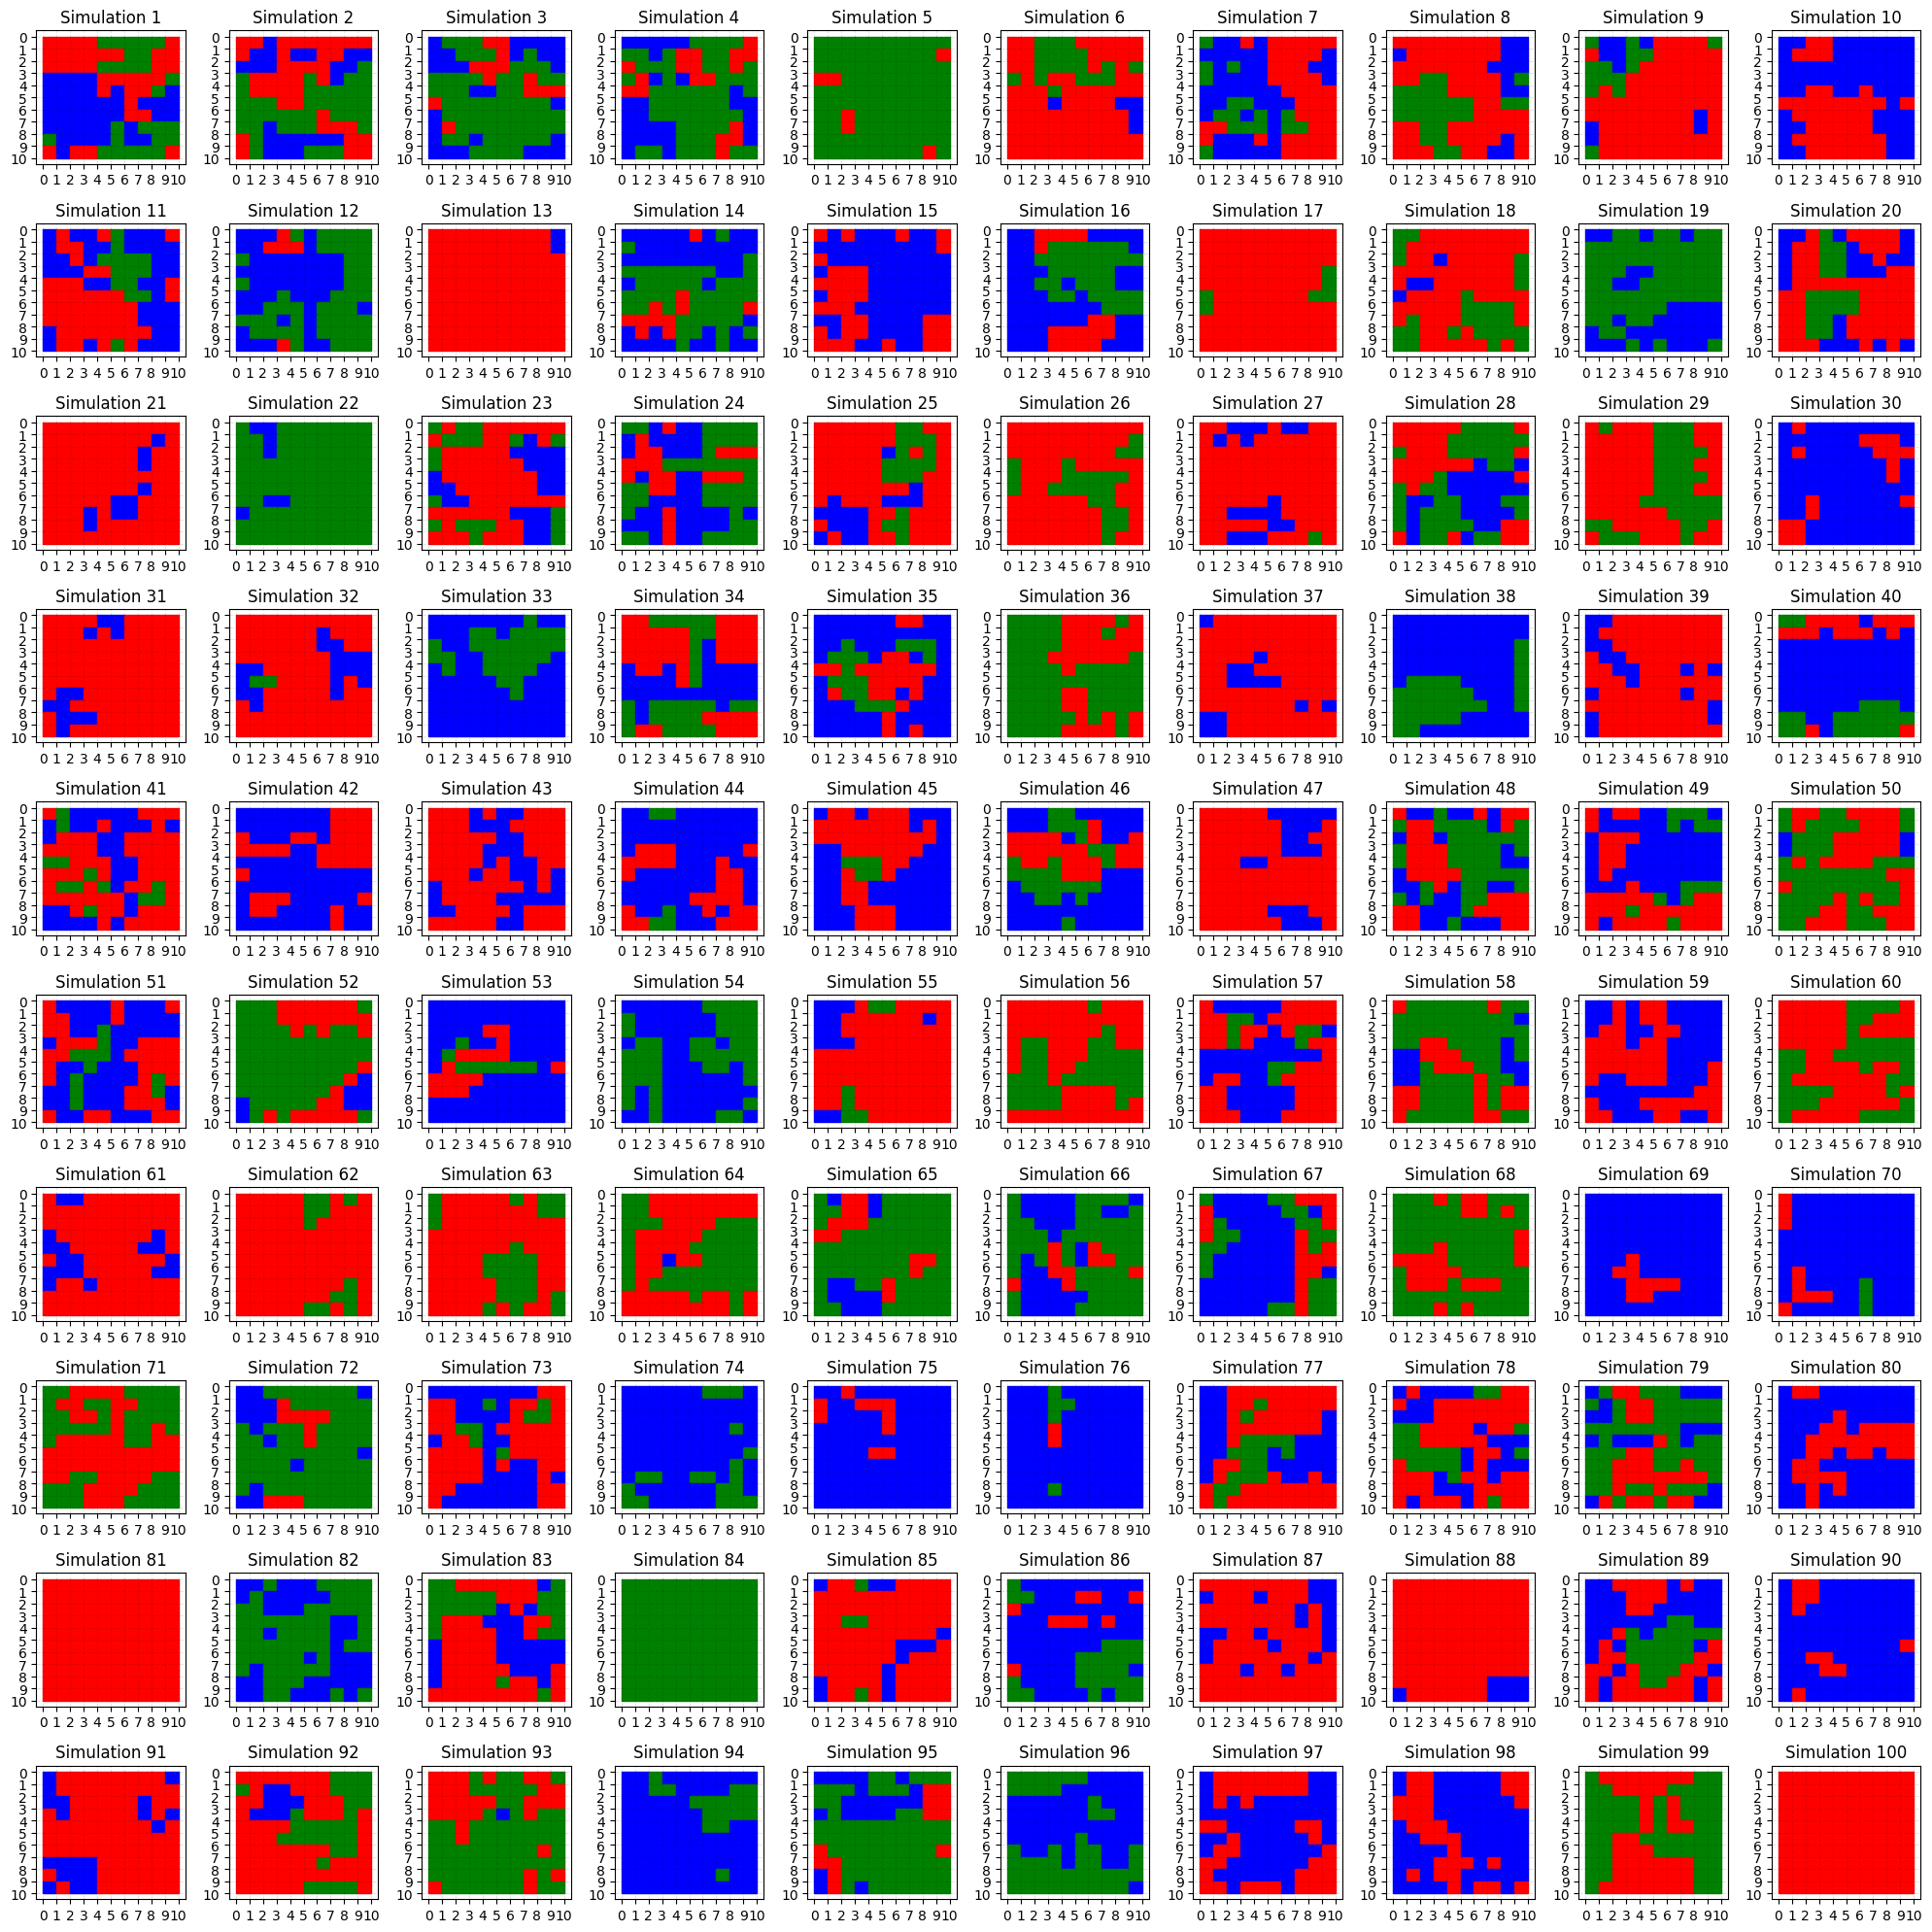

In [ ]:
num_rows = 10  # Number of rows
num_cols = 10  # Number of columns (equal to the number of simulations)

# Create a single figure with subplots for each simulation
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axs array to loop through it
axs = axs.flatten()

# Loop through each simulation
for sim_index, (sim_data_key, sim_data) in enumerate(data.items()):
    ax = axs[sim_index] if num_rows > 1 else axs  # Get the appropriate subplot

    for voter, chosen_player in sim_data:
        x, y = voter_positions[voter]
        ax.fill([x, x+1, x+1, x], [y, y, y+1, y+1], color=color_map[chosen_player])

    ax.set_title(f'Simulation {sim_data_key + 1}')
    ax.set_xticks(range(11))
    ax.set_yticks(range(11))
    ax.invert_yaxis()
    ax.grid(True, linestyle='--', alpha=0.1, color='black')

# Adjust spacing between subplots
plt.tight_layout()

# Hide empty subplots (if any)
for ax in axs[len(data):]:
    ax.axis('off')

# Show the figure
plt.show()



In [ ]:
# For each voter, select the player with the highest frequency.
most_common_players = {}
for voter, player_freq in voter_player_frequency.items():
    most_common_players[voter] = max(player_freq, key=player_freq.get)

# Create a graph with edges connecting each voter to their most common player.
G_final = nx.Graph()
G_final.add_nodes_from(df_MVP['Voter'], bipartite=0)
G_final.add_nodes_from(player_names, bipartite=1)
G_final.add_edges_from(most_common_players.items())


# Visualize the resulting bipartite graph.
plt.figure(figsize=(5, 5))
edge_colors = [color_map[nominee] for voter, nominee in G_final.edges() if G_final.nodes[nominee]["bipartite"] == 1 or G_final.nodes[voter]["bipartite"] == 1]
pos = nx.bipartite_layout(G_final, df_MVP['Voter'])  # Using bipartite layout
nx.draw(G_final, pos, with_labels=False, edge_color = edge_colors, width = 0.2, node_size = 0.1)
plt.title('Most Common Player for Each Voter Across All Simulations')
plt.show()